In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/MyDrive/DeepLearning/PowerProp/'

/content/drive/MyDrive/DeepLearning/PowerProp


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import torch

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'You are using device: {device}')

You are using device: cuda


In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset

from utils import utils as uu
from utils.loading import load_data
from utils.pp_modules import CNN, MLP


model_seed = 0
torch.manual_seed(model_seed)

In [6]:
# Training Configuration

dataset = 'MNIST'  # be sure to change model type inside loop below
alphas = [1.0, 2.0, 3.0, 4.0, 5.0]
report_interval = 2500

# Training Hyperparameters
train_batch_size = 60
num_train_steps = 50000
learning_rate = 0.01
momentum = 0.0

# load data
train_x, train_y = load_data(dataset, train=True)
test_x, test_y = load_data(dataset, train=False)

train_x = train_x.to(device)
test_x = test_x.to(device)
train_y = train_y.to(device)
test_y = test_y.to(device)

dataloader = DataLoader(TensorDataset(train_x, train_y), batch_size=train_batch_size, shuffle=True)

In [7]:
def prune_by_magnitude(percent_to_keep, weight):
    condition = torch.abs(weight.flatten())
    how_many = int(percent_to_keep * torch.numel(condition))
    top_k = torch.topk(condition, k=how_many)

    mask = torch.zeros(condition.shape).to(device)
    mask[top_k.indices] = 1

    return mask.reshape(weight.shape)


def evaluate_pruning(alpha, model, test_x, test_y, criterion):
    final_weights = model.get_weights()
    sparsity_levels = np.geomspace(0.01, 1.0, 20).tolist()
    acc_at_sparsity = []
    for p_to_use in sparsity_levels:
        # Half the sparsity at output layer
        percent = [p_to_use, p_to_use, min(1.0, p_to_use * 2.0)]
        masks = []
        for p, w in zip(percent, final_weights):
            masks.append(prune_by_magnitude(p, w))

        loss, acc = uu.evaluate(model, test_x, test_y, criterion, masks=masks)
        acc_at_sparsity.append(acc)

    return acc_at_sparsity


In [8]:
model_types = []
for alpha in alphas:
    if alpha > 1.0:
        model_types.append('Powerprop. ($\\alpha={}$)'.format(alpha))
    else:
        model_types.append('Baseline')

repetitions = 5
total_results = []
total_weights = []
for r in range(repetitions):
    round_results = []
    weight_results = []
    for alpha in alphas:
        print(f'Rep {r}, Alpha={alpha}')
        model = MLP(alpha=alpha).to(device)
        model.apply(uu.init_weights)

        initial_weights = model.get_weights()

        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
        CE_loss = torch.nn.CrossEntropyLoss()

        uu.train(model, dataloader, optimizer, CE_loss, training_steps=num_train_steps)

        final_weights = model.get_weights()

        test_loss, test_acc = uu.evaluate(model, test_x, test_y, CE_loss)
        print(f'Test Set [alpha={alpha}]:\tLoss={test_loss:.4f}\tAcc={test_acc:.4f}')

        pruning_accs = evaluate_pruning(alpha, model, test_x, test_y, CE_loss)
        round_results.append(pruning_accs)
        weight_results.append((initial_weights, final_weights))
    
    total_results.append(round_results)
    total_weights.append(weight_results)
    # total_results structure:
    # top level: results for each repetition (5)
    # bottom level: results by alpha for a given repetition

Rep 0, Alpha=1.0
Interval: [0][0/50000]	Loss=2.3299 (2.3299)	Acc=0.0500 (0.0500)
Interval: [1][2500/50000]	Loss=0.2558 (0.6063)	Acc=0.9000 (0.8505)
Interval: [2][5000/50000]	Loss=0.1916 (0.4392)	Acc=0.9333 (0.8868)
Interval: [3][7500/50000]	Loss=0.1614 (0.3653)	Acc=0.9833 (0.9040)
Interval: [4][10000/50000]	Loss=0.1177 (0.3187)	Acc=0.9833 (0.9153)
Interval: [5][12500/50000]	Loss=0.2081 (0.2855)	Acc=0.9333 (0.9236)
Interval: [6][15000/50000]	Loss=0.1163 (0.2600)	Acc=0.9833 (0.9301)
Interval: [7][17500/50000]	Loss=0.0809 (0.2394)	Acc=0.9833 (0.9354)
Interval: [8][20000/50000]	Loss=0.0325 (0.2222)	Acc=1.0000 (0.9399)
Interval: [9][22500/50000]	Loss=0.0459 (0.2076)	Acc=1.0000 (0.9437)
Interval: [10][25000/50000]	Loss=0.0380 (0.1951)	Acc=1.0000 (0.9470)
Interval: [11][27500/50000]	Loss=0.0572 (0.1840)	Acc=1.0000 (0.9500)
Interval: [12][30000/50000]	Loss=0.0623 (0.1743)	Acc=0.9833 (0.9527)
Interval: [13][32500/50000]	Loss=0.0397 (0.1656)	Acc=1.0000 (0.9550)
Interval: [14][35000/50000]	Loss=0

In [9]:
# save weights just to avoid repeated training

np.save(r'./images/mnist_weights_before_after_lr01_m0.npy', np.array(total_weights))

In [10]:
arr = np.array(total_results)

np.save(r'./images/mnist_sparsity_performance_lr01_m0.npy', arr)
means = arr.mean(axis=0)
stds = arr.std(axis=0)

In [11]:
(arr[1, 1] == np.array(total_results[1][1])).all()

True

In [12]:
means[0]

array([0.14304   , 0.14934   , 0.15456   , 0.1661    , 0.18502   ,
       0.24573999, 0.36153999, 0.46559999, 0.52261998, 0.61037999,
       0.6735    , 0.79203998, 0.88613999, 0.93553997, 0.95409998,
       0.97165998, 0.97619997, 0.97721997, 0.97771996, 0.97791997])

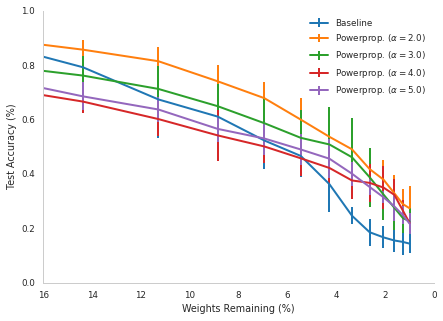

In [15]:
sns.set_style("whitegrid")
sns.set_context("paper")

sparsity_levels = 100 * np.geomspace(0.01, 1.0, 20)

f, ax = plt.subplots(1, 1, figsize=(7, 5))
for i, label in enumerate(model_types):
    ax.errorbar(sparsity_levels, means[i], yerr=stds[i], label=label, lw=2)

ax.set_xlim([16, 0.0])
ax.set_ylim([0.0, 1.0])
ax.legend(frameon=False)
ax.grid(False)
ax.set_xlabel('Weights Remaining (%)')
ax.set_ylabel('Test Accuracy (%)')

sns.despine()
f.savefig('images/mnist_sparsity_performance_lr01_m0_grid_off.png')

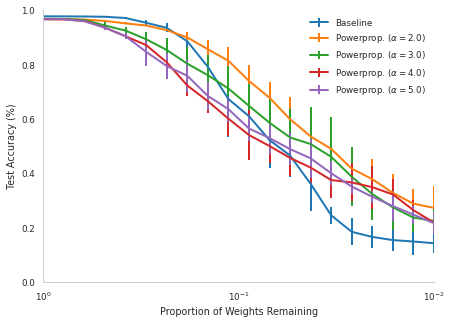

In [14]:
sns.set_style("whitegrid")
sns.set_context("paper")

sparsity_levels = np.geomspace(0.01, 1.0, 20)

f, ax = plt.subplots(1, 1, figsize=(7, 5))
for i, label in enumerate(model_types):
    ax.errorbar(sparsity_levels, means[i], yerr=stds[i], label=label, lw=2)

ax.set_xscale('log')
ax.set_xlim([1.0, 0.01])
ax.set_ylim([0.0, 1.0])
ax.legend(frameon=False)
ax.grid(False)
ax.set_xlabel('Proportion of Weights Remaining')
ax.set_ylabel('Test Accuracy (%)')

sns.despine()
f.savefig('images/mnist_sparsity_performance_log_lr01_m0.png')